In [1]:
import numpy as np
import scipy as sp
from imp import reload

from scipy.stats import chi2,lognorm, norm, spearmanr, pearsonr, linregress
from statsmodels.stats import multitest
from scipy.optimize import curve_fit

import matplotlib
from matplotlib import rc
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
%matplotlib inline

bp={'color':'black','linewidth':2}
mp={'color':'#e50303','linewidth':2}
fp={'markersize':12,'color':'black'}

rc('text', usetex=False)
rc('font', **{'family': 'sans-serif', 'sans-serif':'DejaVu Sans'})
rc('mathtext', **{'fontset': 'custom', 'rm':'DejaVu Sans', 'it':'DejaVu Sans:italic', 'bf':'DejaVu Sans:bold'})

def BIC_MEM(L, N, ntot, k_F, k_R):
    """Computes the BIC for Mixed Effect Models introduced in Delattre & Poursat, arXiv, 2016.
    The original manuscript can be found at: http://arxiv.org/abs/1612.02405
    Arguments:
    ----------
    L (float): -2 log-Likelihood of the model
    N (int): population size (number of individuals)
    ntot (int): total sample size (number of individuals*number of observables*number of timepoints)
    k_F (int): number of population parameters defining fixed parameters (= number of fixed effects for the fixed parameters)
    k_R (int): number of population parameters defininf rand parameters (= number of fixed effects for the random parameters + number of non-null elements of the variance-covariance matrix of the random effects)

    Returns:
    --------
    BIC (float): BIC of the model"""

    BIC = L + np.log(N)*k_R + np.log(ntot)*k_F
    return(BIC)

# Model with variability on the initial condition and no variability on the kinetic parameters

In [2]:
pop_params_names=(r'$\rho_S^{pop}$', r'$\rho_C^{pop}$', r'$\rho_B^{pop}$', r'$S_0^{pop}$', r'$T_0^{pop}$', r'$\omega_{S_0}$', r'$\omega_{T_0}$', r'$b_1$', r'$b_2$', r'$b_3$')     
n_pop_params=len(pop_params_names)  #number of parameters
n_pop_params_avg = 5
n_pop_params_variances = 2
n_rep=50  #number of replicates

CA_logLikelihood = np.empty(n_rep)
CA_AIC = np.empty(n_rep)
CA_Pop_params    = np.empty((n_pop_params, n_rep))
CA_Pop_params_se = np.empty((n_pop_params, n_rep))

for i in range(n_rep):
    ll, aic = np.genfromtxt('../data/Initial_Condition_Variability/ReducedModel_InitialConditionVariability/Assessment/Run%i/LogLikelihood/logLikelihood.txt'%(i+1), skip_header=1, usecols=(1), skip_footer=2)   
    CA_logLikelihood[i] = ll
    CA_AIC[i] = aic
    data = np.genfromtxt('../data/Initial_Condition_Variability/ReducedModel_InitialConditionVariability/Assessment/Run%i/populationParameters.txt'%(i+1), skip_header=1, usecols=(1, 2), invalid_raise=False)
    CA_Pop_params[:,i] = data[:,0]
    CA_Pop_params_se[:,i] = data[:,1]

likelihood = np.min(CA_logLikelihood)
CA_D_AIC = CA_AIC - np.min(CA_AIC)
CA_w_AIC = np.exp(-0.5*CA_D_AIC)/np.sum(np.exp(-0.5*CA_D_AIC))

arg=np.argsort(CA_AIC) #list of models indexes sorted by increasing AICc
Best_runs_w = [] #list of best models according to the Akaike's weight
Weights_sorted=np.sort(CA_w_AIC)[::-1] #list of models Akaike's weights sorted decreasingly

#Building the ranking by Aikaike's weights
imax=0
while np.sum(Weights_sorted[:imax]) <=0.95:
    Best_runs_w+=[arg[imax]]
    imax+=1

for i in range(imax,n_rep):   
    CA_Pop_params[:,arg[i]] = None
    CA_Pop_params_se[:,arg[i]] = None
mask = np.logical_not(np.isnan(CA_Pop_params[0]))

/usr/local/lib/python3.6/dist-packages/ipykernel/__main__.py:16: ConversionWarning: Some errors were detected !
    Line #3 (got 2 columns instead of 2)
    Line #5 (got 2 columns instead of 2)
    Line #6 (got 2 columns instead of 2)
/usr/local/lib/python3.6/dist-packages/ipykernel/__main__.py:16: ConversionWarning: Some errors were detected !
    Line #3 (got 2 columns instead of 2)
    Line #5 (got 2 columns instead of 2)
    Line #6 (got 2 columns instead of 2)
/usr/local/lib/python3.6/dist-packages/ipykernel/__main__.py:16: ConversionWarning: Some errors were detected !
    Line #3 (got 2 columns instead of 2)
    Line #5 (got 2 columns instead of 2)
    Line #6 (got 2 columns instead of 2)
/usr/local/lib/python3.6/dist-packages/ipykernel/__main__.py:16: ConversionWarning: Some errors were detected !
    Line #3 (got 2 columns instead of 2)
    Line #5 (got 2 columns instead of 2)
    Line #6 (got 2 columns instead of 2)
/usr/local/lib/python3.6/dist-packages/ipykernel/__main__.py

In [3]:
print("\nNumber of convergent runs according to w_AIC: %i\n"%imax)
print("Convergent runs according to w_AIC:\n", Best_runs_w, '\n')
print('\n\t Best run likelihood:\t%.6g\n'%likelihood)
print('\n\t Best run BIC:\t%.6g\n'%BIC_MEM(likelihood, 7, 105, 3, 4))


Number of convergent runs according to w_AIC: 24

Convergent runs according to w_AIC:
 [32, 47, 48, 23, 45, 39, 30, 49, 35, 8, 42, 36, 9, 46, 25, 41, 33, 18, 44, 2, 31, 26, 34, 13] 


	 Best run likelihood:	1800.62


	 Best run BIC:	1822.36



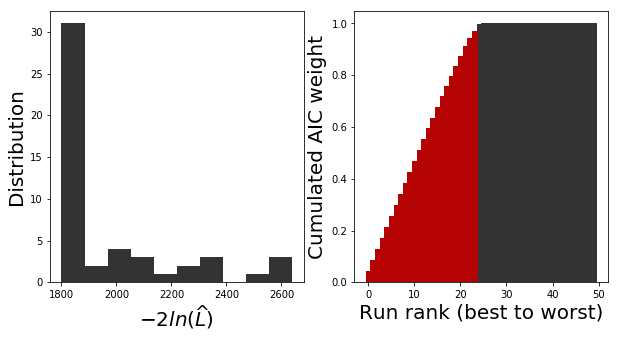

In [18]:
plt.rcParams['figure.figsize']=10,5
f,ax=plt.subplots(1,2)

ax[0].hist(CA_logLikelihood, color='0.2')
yrange=ax[0].get_ylim()
ax[0].set_ylim(yrange)
ax[0].set_xlabel(r'$-2ln(\widehat{L})$', fontsize=20)
ax[0].set_ylabel('Distribution', fontsize=20)

ax[1].bar(np.arange(n_rep),np.cumsum(np.sort(CA_w_AIC)[::-1]),1,facecolor='0.2',edgecolor='0.2')
ax[1].bar(np.arange(imax),np.cumsum(np.sort(CA_w_AIC)[::-1])[:imax],1,facecolor='#b50303',edgecolor='#b50303')
ax[1].set_xlabel('Run rank (best to worst)',fontsize=20)
ax[1].set_ylabel('Cumulated AIC weight',fontsize=20)

savefig=True
if savefig:
    plt.savefig('../figures/Initial_Condition_Variability/ReducedModel_InitialConditionVariability/ReducedModel_InitialConditionVariability_AIC.pdf', dpi='figure', bbox_inches='tight')   

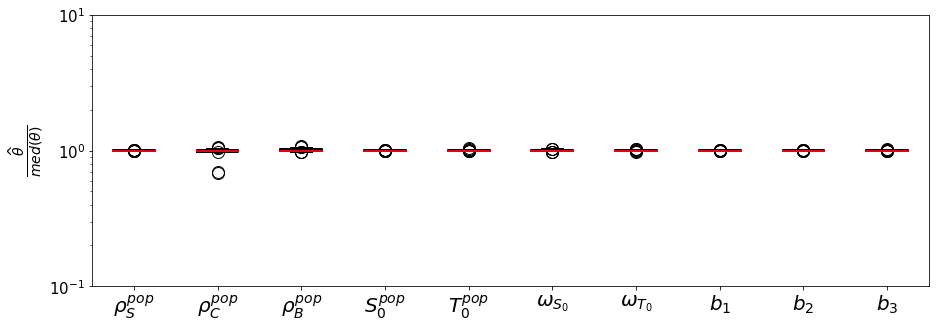

In [19]:
plt.rcParams['figure.figsize'] = 15, 5

plt.boxplot(CA_Pop_params.T[mask.T]/np.nanmedian(CA_Pop_params, axis=1), whis=(10,90), boxprops=bp, capprops=bp, whiskerprops=bp, medianprops=mp, flierprops=fp)    
plt.yscale('log')
plt.xticks(range(1,n_pop_params+1), labels=pop_params_names, fontsize=20)
plt.yticks([0.1, 1, 10], fontsize=15)
plt.ylabel(r'$\frac{\widehat{\theta}}{med(\theta)}$', fontsize=20)

savefig=True
if savefig:
    plt.savefig('../figures/Initial_Condition_Variability/ReducedModel_InitialConditionVariability/ReducedModel_InitialConditionVariability_PopulationParameters_boxplot_normalized.pdf', dpi='figure', bbox_inches='tight')   

In [3]:
indiv_params_names = (r'$S_0$', r'$T_0$')

n_indiv=7
Indiv_Random_Effects = np.empty((n_pop_params_variances, n_rep, n_indiv))
Eta_shrinkage = np.empty((n_pop_params_variances, n_rep))
for i in range(n_rep):
    data = np.genfromtxt('../data/Initial_Condition_Variability/ReducedModel_InitialConditionVariability/Assessment/Run%i/IndividualParameters/estimatedRandomEffects.txt'%(i+1), skip_header=1, usecols = (7,8))     
    Indiv_Random_Effects[:,i] = data.T
for j in range(n_pop_params_variances):
    data = Indiv_Random_Effects[j]/CA_Pop_params[n_pop_params_avg+j][:,None]
    #print('\t', data)
    s_eta = 1-np.std(data, axis=1)
    Eta_shrinkage[j] = s_eta

mask_shrinkage = ~np.isnan(Eta_shrinkage)
Filtered_Eta_Shrinkage = np.array([d[m] for d, m in zip(Eta_shrinkage, mask_shrinkage)])

Average shrinkage for each parameter:
 [0.13869718 0.07567477]


/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


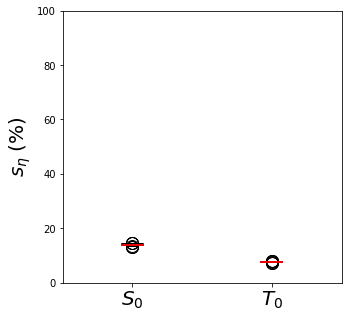

In [4]:
plt.rcParams['figure.figsize'] = 5, 5

plt.boxplot(100*Filtered_Eta_Shrinkage.T, whis=(10,90), boxprops=bp, capprops=bp, whiskerprops=bp, medianprops=mp, flierprops=fp)    
plt.xticks(range(1,3), labels=indiv_params_names, fontsize=20)
plt.ylabel(r'$s_{\eta} \; (\%)$', fontsize=20)
plt.ylim(0,100)

print('Average shrinkage for each parameter:\n',np.nanmean(Eta_shrinkage, axis=1))

savefig = True
if savefig:
    plt.savefig('../figures/Initial_Condition_Variability/ReducedModel_InitialConditionVariability/ReducedModel_InitialConditionVariability_Shrinkage.pdf', dpi='figure', bbox_inches='tight')

# Model with variability on the parameters and the initial condition

In [4]:
pop_params_names=(r'$\rho_S^{pop}$', r'$\rho_C^{pop}$', r'$\rho_B^{pop}$', r'$S_0^{pop}$', r'$T_0^{pop}$', r'$\omega_{\rho_S}$', r'$\omega_{\delta_{SC}}$', r'$\omega_{\delta_{CB}}$', r'$\omega_{S_0}$', r'$\omega_{T_0}$', r'$b_1$', r'$b_2$', r'$b_3$')     
n_pop_params=len(pop_params_names)  #number of parameters
n_pop_params_avg = 5
n_pop_params_variances = 5
n_rep=50  #number of replicates

CA_logLikelihood = np.empty(n_rep)
CA_AIC = np.empty(n_rep)
CA_Pop_params    = np.empty((n_pop_params, n_rep))
CA_Pop_params_se = np.empty((n_pop_params, n_rep))

for i in range(n_rep):
    ll, aic = np.genfromtxt('../data/Initial_Condition_Variability/ReducedModel_InitialCondition&ParametersVariability/Assessment/Run%i/LogLikelihood/logLikelihood.txt'%(i+1), skip_header=1, usecols=(1), skip_footer=2)   
    CA_logLikelihood[i] = ll
    CA_AIC[i] = aic
    data = np.genfromtxt('../data/Initial_Condition_Variability/ReducedModel_InitialCondition&ParametersVariability/Assessment/Run%i/populationParameters.txt'%(i+1), skip_header=1, usecols=(1, 2), invalid_raise=False)
    CA_Pop_params[:,i] = data[:,0]
    CA_Pop_params_se[:,i] = data[:,1]

likelihood = np.min(CA_logLikelihood)
        
CA_D_AIC = CA_AIC - np.min(CA_AIC)
CA_w_AIC = np.exp(-0.5*CA_D_AIC)/np.sum(np.exp(-0.5*CA_D_AIC))

arg=np.argsort(CA_AIC) #list of models indexes sorted by increasing AICc
Best_runs_w = [] #list of best models according to the Akaike's weight
Weights_sorted=np.sort(CA_w_AIC)[::-1] #list of models Akaike's weights sorted decreasingly

#Building the ranking by Aikaike's weights
imax=0
while np.sum(Weights_sorted[:imax]) <=0.95:
    Best_runs_w+=[arg[imax]]
    imax+=1

for i in range(imax, n_rep):   
        CA_Pop_params[:,arg[i]] = None
        CA_Pop_params_se[:,arg[i]] = None
mask = np.logical_not(np.isnan(CA_Pop_params[0]))

/usr/local/lib/python3.6/dist-packages/ipykernel/__main__.py:16: ConversionWarning: Some errors were detected !
    Line #3 (got 2 columns instead of 2)
    Line #5 (got 2 columns instead of 2)
    Line #6 (got 2 columns instead of 2)
/usr/local/lib/python3.6/dist-packages/ipykernel/__main__.py:16: ConversionWarning: Some errors were detected !
    Line #3 (got 2 columns instead of 2)
    Line #5 (got 2 columns instead of 2)
    Line #6 (got 2 columns instead of 2)
/usr/local/lib/python3.6/dist-packages/ipykernel/__main__.py:16: ConversionWarning: Some errors were detected !
    Line #3 (got 2 columns instead of 2)
    Line #5 (got 2 columns instead of 2)
    Line #6 (got 2 columns instead of 2)
/usr/local/lib/python3.6/dist-packages/ipykernel/__main__.py:16: ConversionWarning: Some errors were detected !
    Line #3 (got 2 columns instead of 2)
    Line #5 (got 2 columns instead of 2)
    Line #6 (got 2 columns instead of 2)
/usr/local/lib/python3.6/dist-packages/ipykernel/__main__.py

/usr/local/lib/python3.6/dist-packages/ipykernel/__main__.py:16: ConversionWarning: Some errors were detected !
    Line #3 (got 2 columns instead of 2)
    Line #5 (got 2 columns instead of 2)
    Line #6 (got 2 columns instead of 2)
/usr/local/lib/python3.6/dist-packages/ipykernel/__main__.py:16: ConversionWarning: Some errors were detected !
    Line #3 (got 2 columns instead of 2)
    Line #5 (got 2 columns instead of 2)
    Line #6 (got 2 columns instead of 2)
/usr/local/lib/python3.6/dist-packages/ipykernel/__main__.py:16: ConversionWarning: Some errors were detected !
    Line #3 (got 2 columns instead of 2)
    Line #5 (got 2 columns instead of 2)
    Line #6 (got 2 columns instead of 2)
/usr/local/lib/python3.6/dist-packages/ipykernel/__main__.py:16: ConversionWarning: Some errors were detected !
    Line #3 (got 2 columns instead of 2)
    Line #5 (got 2 columns instead of 2)
    Line #6 (got 2 columns instead of 2)
/usr/local/lib/python3.6/dist-packages/ipykernel/__main__.py

In [5]:
print("\nNumber of convergent runs according to w_AIC: %i\n"%imax)
print("Convergent runs according to w_AIC:\n", Best_runs_w, '\n')
print('\n\t Best Likelihood:\t%.6g\n'%likelihood)
print('\n\t Best BIC a:\t%.6g\n'%BIC_MEM(likelihood, 7, 105, 2, 8))
print('\n\t Best BIC b:\t%.6g\n'%BIC_MEM(likelihood, 7, 105, 1, 9))


Number of convergent runs according to w_AIC: 24

Convergent runs according to w_AIC:
 [41, 18, 39, 35, 1, 47, 31, 43, 45, 9, 12, 19, 48, 49, 20, 46, 32, 6, 11, 2, 36, 8, 30, 26] 


	 Best Likelihood:	1759.49


	 Best BIC a:	1784.36


	 Best BIC b:	1781.66



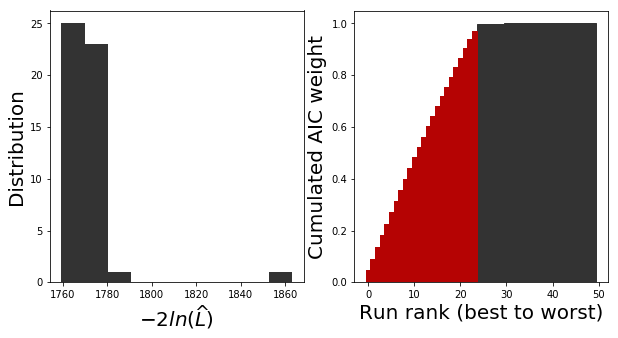

In [25]:
plt.rcParams['figure.figsize']=10,5
f,ax=plt.subplots(1,2)

ax[0].hist(CA_logLikelihood, color='0.2')
yrange=ax[0].get_ylim()
ax[0].set_ylim(yrange)
ax[0].set_xlabel(r'$-2ln(\widehat{L})$', fontsize=20)
ax[0].set_ylabel('Distribution', fontsize=20)

ax[1].bar(np.arange(n_rep),np.cumsum(np.sort(CA_w_AIC)[::-1]),1,facecolor='0.2',edgecolor='0.2')
ax[1].bar(np.arange(imax),np.cumsum(np.sort(CA_w_AIC)[::-1])[:imax],1,facecolor='#b50303',edgecolor='#b50303')
ax[1].set_xlabel('Run rank (best to worst)',fontsize=20)
ax[1].set_ylabel('Cumulated AIC weight',fontsize=20)

savefig=True
if savefig:
    plt.savefig('../figures/Initial_Condition_Variability/ReducedModel_InitialCondition&ParametersVariability/ReducedModel_InitialCondition&ParameterVariability_AIC.pdf', dpi='figure', bbox_inches='tight')   

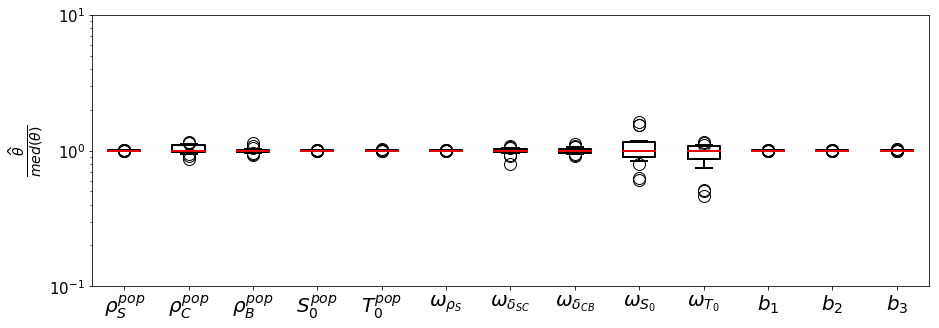

In [26]:
plt.rcParams['figure.figsize'] = 15, 5

plt.boxplot(CA_Pop_params.T[mask.T]/np.nanmedian(CA_Pop_params, axis=1), whis=(10,90), boxprops=bp, capprops=bp, whiskerprops=bp, medianprops=mp, flierprops=fp)    
plt.yscale('log')
plt.xticks(range(1,n_pop_params+1), labels=pop_params_names, fontsize=20)
plt.yticks([0.1, 1, 10], fontsize=15)
plt.ylabel(r'$\frac{\widehat{\theta}}{med(\theta)}$', fontsize=20)

savefig=True
if savefig:
    plt.savefig('../figures/Initial_Condition_Variability/ReducedModel_InitialCondition&ParametersVariability/ReducedModel_InitialCondition&ParameterVariability_PopulationParameters_boxplot_normalized.pdf', dpi='figure', bbox_inches='tight')   

In [6]:
indiv_params_names = (r'$\rho_S$', r'$\delta_{SC}$', r'$\delta_{CB}$', r'$S_0$', r'$T_0$')

n_indiv=7
Indiv_Random_Effects = np.empty((n_pop_params_variances, n_rep, n_indiv))
Eta_shrinkage = np.empty((n_pop_params_variances, n_rep))
for i in range(n_rep):
    data = np.genfromtxt('../data/Initial_Condition_Variability/ReducedModel_InitialCondition&ParametersVariability/Assessment/Run%i/IndividualParameters/estimatedRandomEffects.txt'%(i+1), skip_header=1, usecols = (1,2,5,7,8))     
    Indiv_Random_Effects[:,i] = data.T
for j in range(n_pop_params_variances):
    data = Indiv_Random_Effects[j]/CA_Pop_params[n_pop_params_avg+j][:,None]
    #print('\t', data)
    s_eta = 1-np.std(data, axis=1)
    Eta_shrinkage[j] = s_eta

mask_shrink = ~np.isnan(Eta_shrinkage)
Filtered_Eta_Shrinkage = np.array([d[m] for d, m in zip(Eta_shrinkage, mask_shrink)])

Average shrinkage for each parameter:
 [0.0286883  0.26449058 0.21700794 0.90166502 0.82984509]


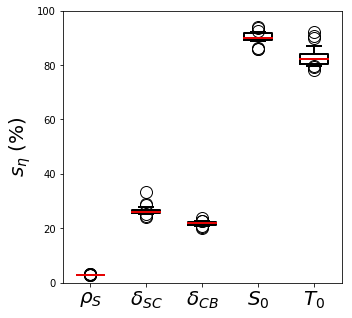

In [7]:
plt.rcParams['figure.figsize'] = 5, 5

plt.boxplot(100*Filtered_Eta_Shrinkage.T, whis=(10,90), boxprops=bp, capprops=bp, whiskerprops=bp, medianprops=mp, flierprops=fp)    
plt.xticks(range(1,6), labels=indiv_params_names, fontsize=20)
plt.ylabel(r'$s_{\eta} \; (\%)$', fontsize=20)
plt.ylim(0,100)

print('Average shrinkage for each parameter:\n',np.nanmean(Eta_shrinkage, axis=1))

savefig = True
if savefig:
    plt.savefig('../figures/Initial_Condition_Variability/ReducedModel_InitialCondition&ParametersVariability/ReducedModel_InitialCondition&ParameterVariability_Shrinkage.pdf', dpi='figure', bbox_inches='tight')   